<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Validación-de-modelos" data-toc-modified-id="Validación-de-modelos-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Validación de modelos</a></span></li><li><span><a href="#Plots-predicción" data-toc-modified-id="Plots-predicción-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plots predicción</a></span></li><li><span><a href="#otros" data-toc-modified-id="otros-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>otros</a></span></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import sys
import os
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
# plt.style.use('seaborn-darkgrid')

In [3]:
sys.path.append('../src')

In [4]:
from prediction.models import gompertz_simple, exp_cdf_nonorm, tanh_KM_cdf, gompertz_cdf_nonorm
from prediction.plot import plot_results_fit
from prediction.plot import fit_and_plot_validation
from preprocessing.andalucia import ods_to_dataframe, preprocess_andalucia
from prediction.prediction import preprocess_data
from prediction.fit import temporal_validation_metric, fit_model

In [5]:

path = "../data/series_provincias_andalucia.csv"

df = pd.read_csv(path)
df = preprocess_andalucia(df)
df.index = df.index.date
# df.set_index("dia", inplace=True)
# df['region'] = df['region'].replace({'andalucia':'total'})

fecha_inicio = dt.date(2020, 3, 1)
val_days = 5
pred_days = 7

## Validación de modelos

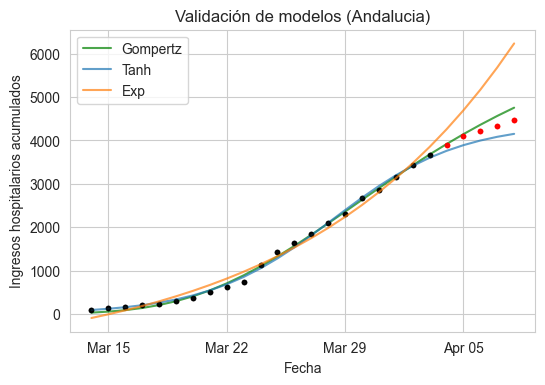

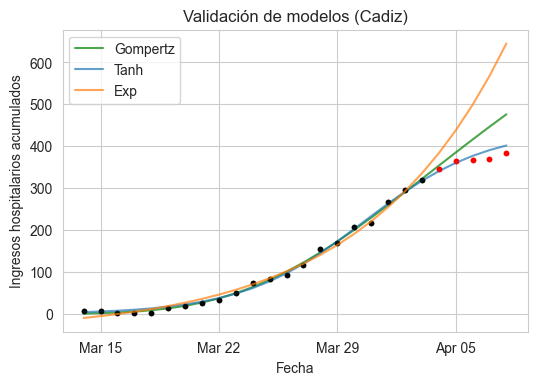

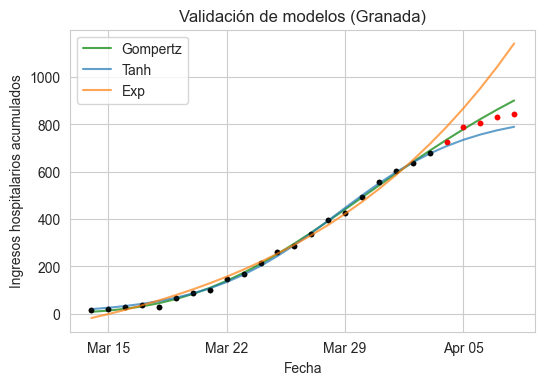

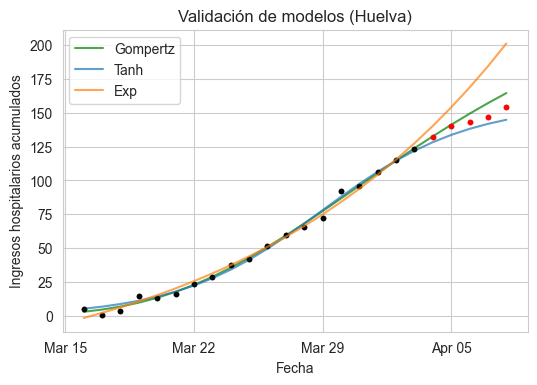

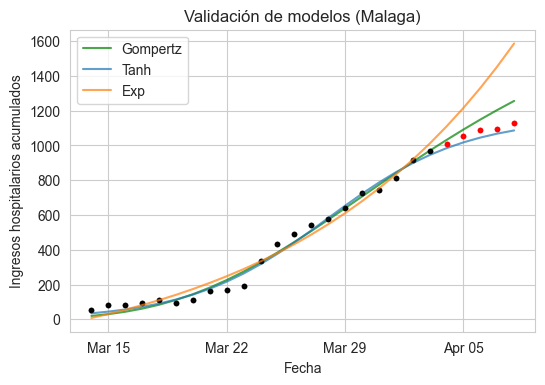

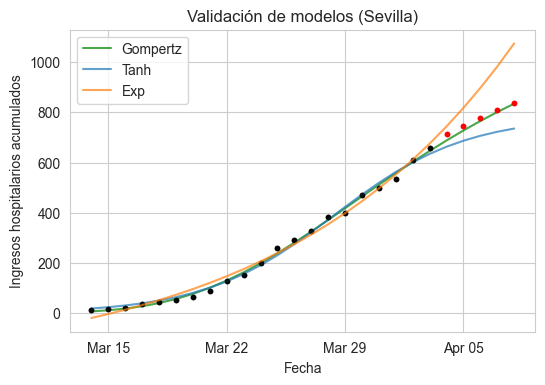

In [6]:
for region in df.region.unique():
    x, y, dydx = preprocess_data(df, region, fecha_inicio)


    plt.figure(dpi=100)
    fit_and_plot_validation(gompertz_simple, x, y,params0=[10000,1000,20], val_days=5,
                                   fecha_inicio=fecha_inicio,kwargs_pred={'color':'green'})
    fit_and_plot_validation(tanh_KM_cdf, x, y,params0=None, val_days=5,
                                   fecha_inicio=fecha_inicio )
    fit_and_plot_validation(exp_cdf_nonorm, x, y,params0=None, val_days=5,
                                   fecha_inicio=fecha_inicio, add_title=region)

## Plots predicción 

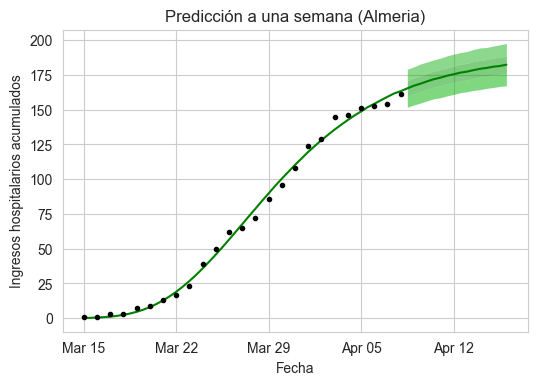

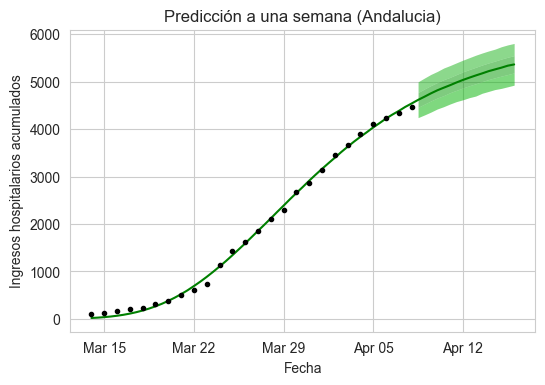

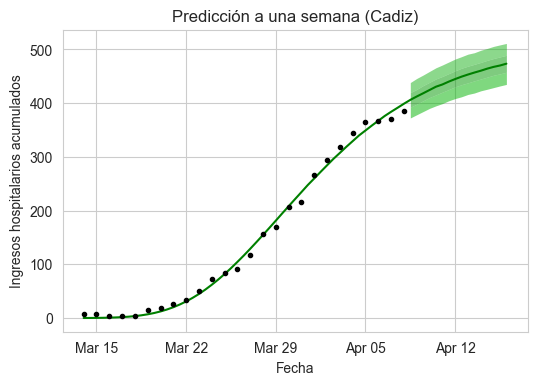

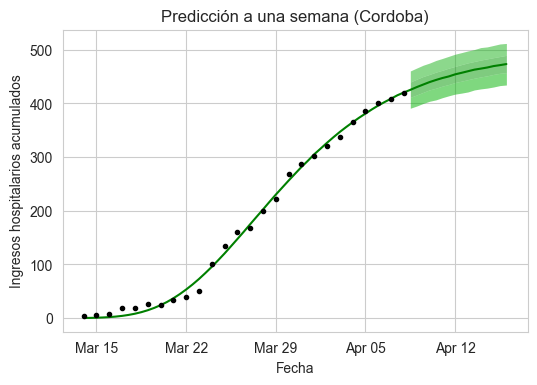

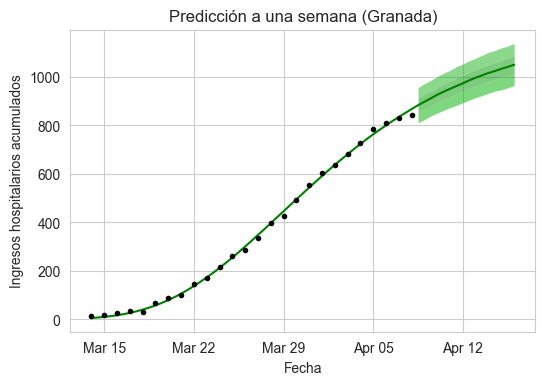

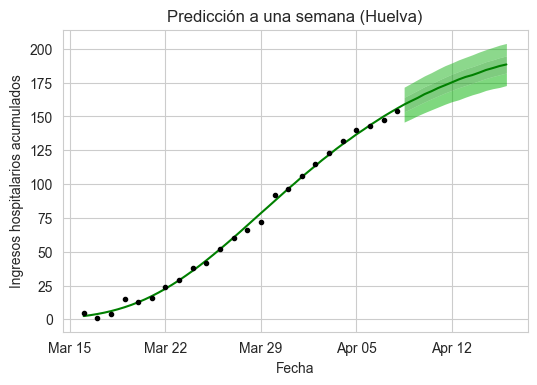

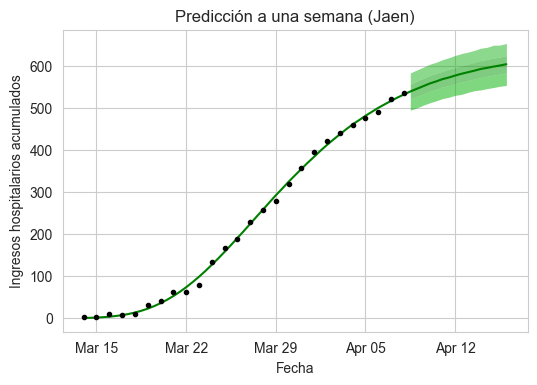

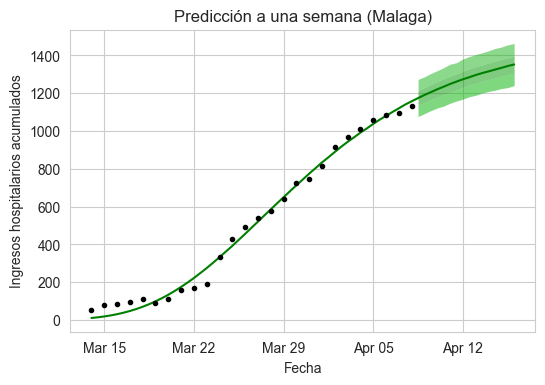

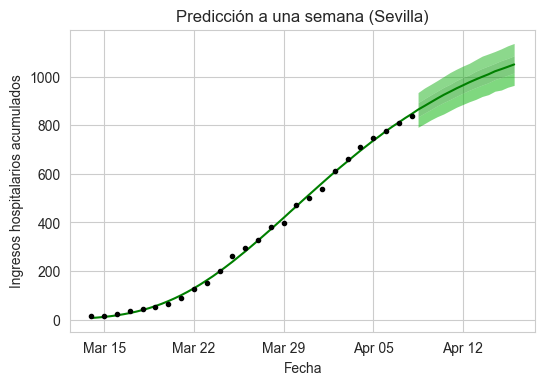

In [12]:
from prediction.plot import plot_prediction_with_uncertainty
from noise.noise import sample_noise

for region in df.region.unique():
    pred_days = 7
    x, y, dydx = preprocess_data(df, region, fecha_inicio)

    model = gompertz_simple
    best_params = fit_model(model, x, y, params0=[10000,1000,20])

    x_pred = np.arange(x.min(), x.max() + 1 + pred_days + .5, .5)
    y_pred = model(x_pred, *best_params)
    f_noise = lambda x: sample_noise(x, n=10000)
    plt.figure(dpi=100)
    plot_prediction_with_uncertainty(x_pred,y_pred,f_noise,
                                     x_orig=x,
                                     y_orig=y,
                                     fecha_inicio=fecha_inicio,
                                     add_title=region,
                                    band_past=False)
    plt.show()

## otros

[6463.72732102  715.46742839   18.94533829]


0.023204385890813507

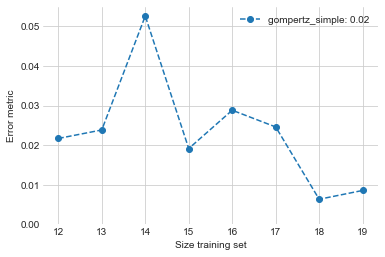

In [57]:
fecha_inicio = dt.date(2020, 3, 1)

x, y, dydx = preprocess_data(df, 'total', fecha_inicio)
params0 = [10000, 1000, 15]
#params0 = None
# y = y[x!=22]
# x = x[x!=22]
model = gompertz_simple
best_params = fit_model(model,x,y, params0=params0)
print(best_params)
# plot_results_fit(model, best_params, x[1:], y[1:], fecha_inicio, predicted_days=7,implicit_plot=True )
temporal_validation_metric(model, x, y, val_size=3, min_train_size=12, params0=params0, plot=True)

In [61]:
y_val_diary = np.diff(y[-(val_size + 1):])
y_pred_diary = np.diff(y_pred)

print("Ground truth:", y_val_diary)
print("Predicted:", y_pred_diary[-val_size:].astype(int))

relative = np.abs(y_pred_diary[-val_size:] - y_val_diary) / y_val_diary
print("Relative error:", np.mean(relative))

Ground truth: [297 229 223 211 120]
Predicted: [166 137 112  89  70]
Relative error: 0.46438657679201756


# Modelos por provincia

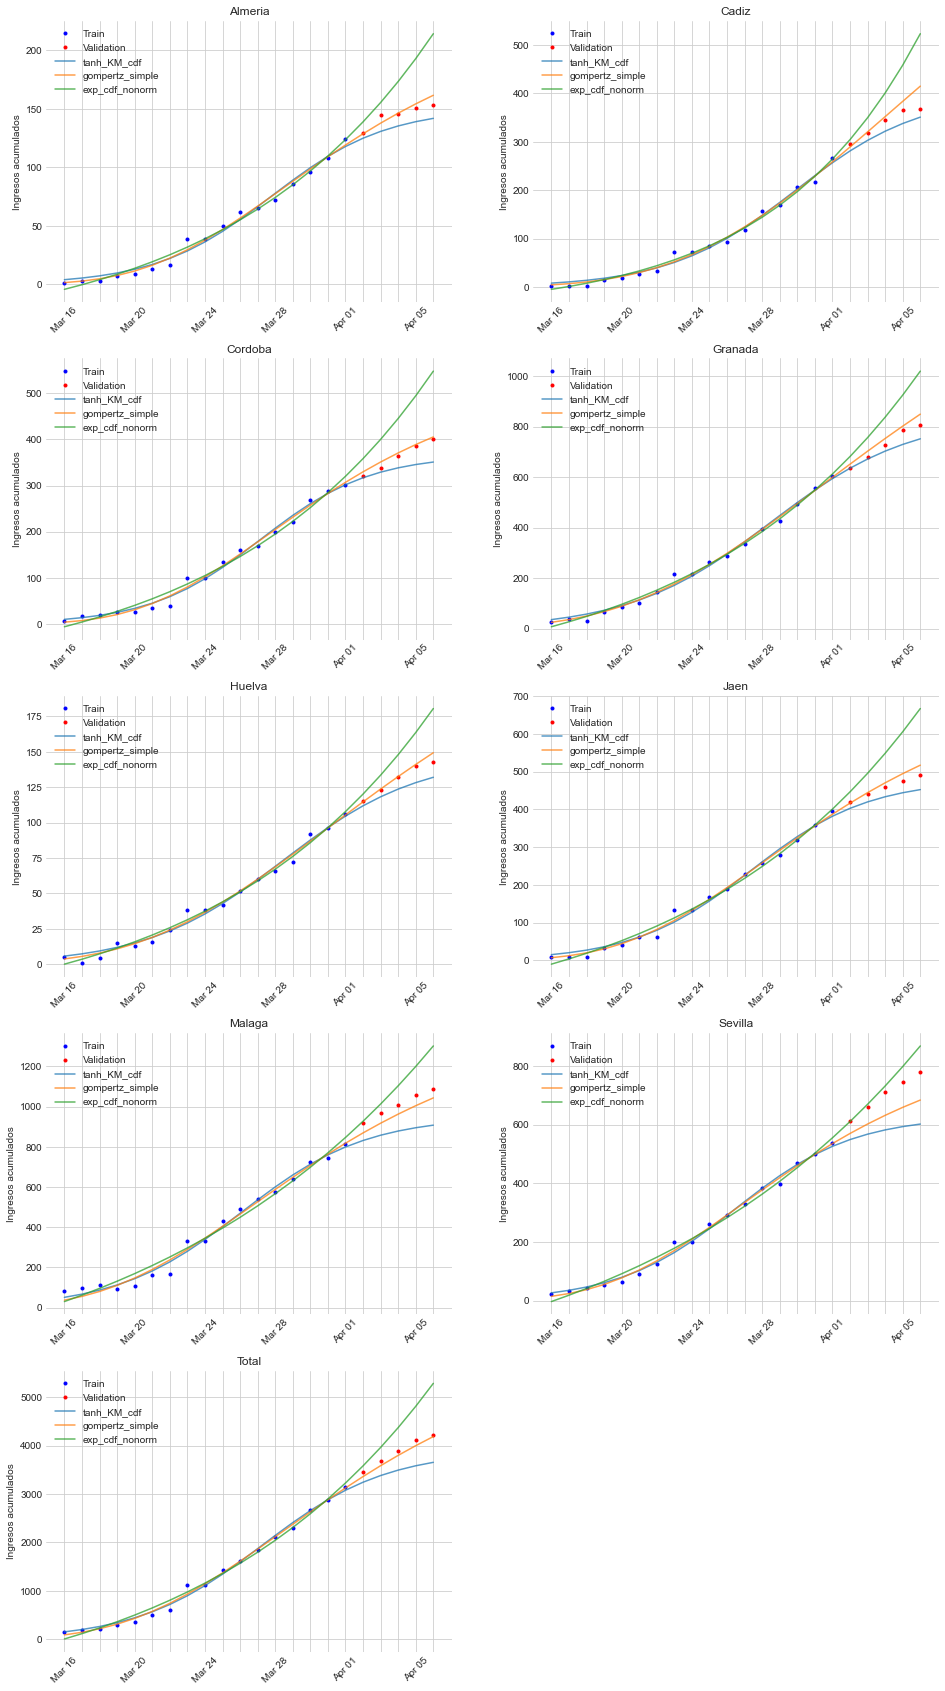

In [62]:
dic_models = {"tanh_KM_cdf": {'a': 50, 'b': 0.13, 'c': 3},
             "gompertz_simple": {"A": 10000, "u": 1000, "d": 15},
             "exp_cdf_nonorm": ["a", "b", "c"]}

val_size = 5
regions = sorted(df.region.unique())

n_plots = len(regions)
ncols = 2
nrows = (n_plots+1)//ncols

plt.figure(figsize=(8*ncols, 6*nrows))

for i, region in enumerate(regions):
    
    plt.subplot(nrows, ncols, i+1)
    plt.title(region.title())
    
    x, y, dydx = preprocess_data(df, region, fecha_inicio)
    
    x_train = x[:-val_size]
    y_train = y[:-val_size]

    x_val = x[-val_size:]
    y_val = y[-val_size:]
    
    plt.plot(x_train, y_train, "b.")
    plt.plot(x_val, y_val, "r.")
    
    for model, params in dic_models.items():
        if type(params) == dict:
            names = list(params.keys())
            params0 = list(params.values())
        else:
            names = params
            params0 = None
            
        best_params = fit_model(eval(model), x_train, y_train, params0=params0)
        best_params = dict(zip(names, best_params))
        
        y_pred = eval(model)(x, **best_params)

        plt.plot(x, y_pred, alpha=.75)
        
    # Ticks
    labels = [""] * df.index.nunique()
    labels[::4] = [item.strftime('%b %d') for item in df.index.unique()[::4]]
    plt.xticks(x, labels, rotation=45)
    
    plt.legend(["Train", "Validation"] + list(dic_models.keys()))
    plt.ylabel("Ingresos acumulados")

plt.show()

# Modelos por Comunidad Autónoma

In [63]:
from isciii_preprocessing import preprocess_isciii

url = "https://covid19.isciii.es/resources/serie_historica_acumulados.csv"
dataset = pd.read_csv(url, encoding='latin1')
dataset = preprocess_isciii(dataset, daily=False)

TypeError: unsupported operand type(s) for -: 'DatetimeIndex' and 'datetime.date'

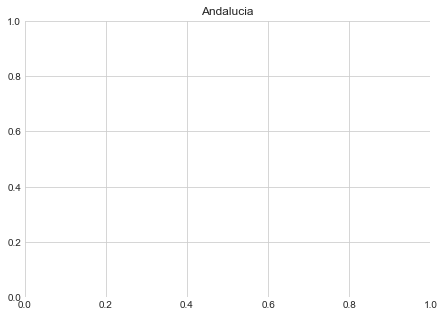

In [64]:
dic_models = {"tanh_KM_cdf": {'a': 50, 'b': 0.13, 'c': 3},
             "gompertz_simple": {"A": 10000, "u": 1000, "d": 15},
             "exp_cdf_nonorm": ["a", "b", "c"]}

val_size = 5
regions = sorted(dataset.region.unique())

n_plots = len(regions)
ncols = 2
nrows = (n_plots+1)//ncols

plt.figure(figsize=(8*ncols, 6*nrows))

for i, region in enumerate(regions):
    
    plt.subplot(nrows, ncols, i+1)
    plt.title(region.title())
    
    x, y, dydx = preprocess_data(dataset, region, fecha_inicio)
    
    x_train = x[:-val_size]
    y_train = y[:-val_size]

    x_val = x[-val_size:]
    y_val = y[-val_size:]
    
    plt.plot(x_train, y_train, "b.")
    plt.plot(x_val, y_val, "r.")
    
    for model, params in dic_models.items():
        if type(params) == dict:
            names = list(params.keys())
            params0 = list(params.values())
        else:
            names = params
            params0 = None
            
        best_params = fit_model(eval(model), x_train, y_train, params0=params0)
        best_params = dict(zip(names, best_params))
        
        y_pred = eval(model)(x, **best_params)

        plt.plot(x, y_pred, alpha=.75)
    
    plt.legend(["Train", "Validation"] + list(dic_models.keys()))
    plt.ylabel("Ingresos acumulados")
    plt.xlabel("Día (a partir del 1 de marzo)")

plt.show()

In [65]:
df[df.region=='total'].ingreso

2020-03-16     160
2020-03-17     200
2020-03-18     223
2020-03-19     307
2020-03-20     367
2020-03-21     503
2020-03-22     616
2020-03-23    1132
2020-03-24    1132
2020-03-25    1433
2020-03-26    1626
2020-03-27    1843
2020-03-28    2106
2020-03-29    2294
2020-03-30    2671
2020-03-31    2867
2020-04-01    3147
2020-04-02    3444
2020-04-03    3673
2020-04-04    3896
2020-04-05    4107
2020-04-06    4227
Name: ingreso, dtype: int64

In [66]:
from fit_total_cases import _fit_model_and_predict
y_pred = _fit_model_and_predict(tanh_KM_cdf,x,y,n_pred=5)
print(y_pred)
# np.diff(np.concat((,y_pred)))

[4323.28278726 4424.78963935 4508.12964581 4575.99163802 4630.87973579]


In [67]:
fecha_inicio = dt.datetime(2020,3,1)

regions = sorted(df.region.unique())
n_plots = len(regions)
ncols = 2
nrows = (n_plots+1)//ncols
plt.figure(figsize=(5*ncols,5*nrows))

for i, region in enumerate(regions):
    x, y, dydx = preprocess_data(df, region, fecha_inicio)

    plt.subplot(nrows, ncols, i+1)
    plt.title(region.title())
    temporal__validation_metric(gompertz_simple, x, y,params0=[10000, 1000, 15], plot=True,plot_kwargs={'linestyle':':'})
    temporal__validation_metric(exp_cdf_nonorm, x, y,plot=True,plot_kwargs={'linestyle':'-.'})
    temporal__validation_metric(tanh_KM_cdf, x, y, params0=[300,.1,10],plot=True)
    
    plt.ylim(0,1)
    
# plt.show()

TypeError: unsupported operand type(s) for -: 'datetime.date' and 'datetime.datetime'

<Figure size 720x1800 with 0 Axes>